In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

#pip install tensorflow
#!pip install keras
#!pip install gensim
#!git clone https://github.com/facebookresearch/fastText.git
#%cd fastText
#!pip install .

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import gensim
import os
import tensorflow
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,LSTM,SimpleRNN,Bidirectional,GlobalAveragePooling1D
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import Accuracy,Recall,Precision
from gensim.models.fasttext import FastText#, load_facebook_model
from gensim.test.utils import datapath, get_tmpfile
from tensorflow import saved_model
import fasttext

## Download and load fasttext Model

In [2]:
#import fasttext.util.util as mesdd
#mesdd.download_model('fr', if_exists='ignore')
fastvectorizer = fasttext.load_model('d:/Sentimanet_classification/cc.fr.300.bin')


## Load Data

In [3]:
data_train = pd.read_excel("fulldataset.xlsx",sheet_name="train")
data_validation = pd.read_excel("fulldataset.xlsx",sheet_name="validation")
data_test = pd.read_excel("fulldataset.xlsx",sheet_name="test")

In [4]:
x_train= data_train["Text"].tolist()
y_train= data_train["Label"].tolist()
x_validation= data_validation["Text"].tolist()
y_validation= data_validation["Label"].tolist()
x_test= data_test["Text"].tolist()
y_test= data_test["Label"].tolist()


# Run this code if using the 6 labels

In [5]:
len(data_validation.index)

1218

In [6]:
data_train.head()

,id,Text,Label
0,268,hahahahahaha nan gros c est grave qd mm on déb...,NONE
1,2262,dit gouine,HOMOPHOBIA
2,5448,rt après 1 an préparation voici plus gros proj...,NONE
3,796,bonjour alicia bon dimanche gros bisous ðÿž ðÿ...,NONE
4,1380,promis damso 31 décembre 2021 arrive an après ...,NONE


In [7]:
max_text_length=300
embed_dim = 300 # size of fasttext vector(fastmodel in my case)
#load fast text vectorizer and the tokenizer
tokenizer= Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index)+1

In [8]:
templiste=[]
for element in x_train:
    templiste.append(str(element))
x_train=[]
x_train=templiste

templiste=[]
for element in x_validation:
    templiste.append(str(element))
x_validation=[]
x_validation=templiste
templiste=[]
for element in x_test:
    templiste.append(str(element))
x_test=[]
x_test=templiste

In [9]:
temp= tokenizer.texts_to_sequences(x_train)
x_train_padded=pad_sequences(temp, maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_validation)
x_validation_padded=pad_sequences(temp,maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_test)
x_test_padded=pad_sequences(temp, maxlen=max_text_length, padding='pre')

In [10]:
# integer encode the data and padd it
y_train_encoded =pd.get_dummies(y_train).values
y_validation_encoded =pd.get_dummies(y_validation).values
y_test_encoded =pd.get_dummies(y_test).values

In [11]:
with open('d:/OMDENA/Marseile/french_tokenizer02.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
len(x_train),len(x_test),len(x_validation)

(9744, 1219, 1218)

In [13]:
# integer encode the data and padd it
temp= tokenizer.texts_to_sequences(x_train)
x_train_padded=pad_sequences(temp, maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_validation)
x_validation_padded=pad_sequences(temp,maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_test)
x_test_padded=pad_sequences(temp, maxlen=max_text_length, padding='pre')


In [14]:
from numpy import zeros
embed_matrix=zeros((vocab_size,embed_dim))
for word, i in tokenizer.word_index.items():
    embed_vector= fastvectorizer[word]#fastvectorizer.wv[word]
      
    if embed_vector is not None:
        embed_matrix[i]=embed_vector
        


In [ ]:
fastvectorizer = None

In [15]:
#EMbedding layer
e = Embedding(input_dim =vocab_size,output_dim =embed_dim, weights=[embed_matrix],input_length= max_text_length, trainable=True)

In [16]:
#RNN model
modele1 = Sequential()
modele1.add(e)
modele1.add(GlobalAveragePooling1D())
modele1.add(Dropout(0.4))
modele1.add(Dense(300, activation="relu"))
modele1.add(Dropout(0.4))
modele1.add(Dense(100, activation="relu"))
modele1.add(Dense(6, activation='softmax'))
modele1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["accuracy",Recall(),Precision()])
print (modele1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          3507000   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                        

In [17]:
save_dir=os.path.join(os.getcwd(),'saved_models')
model_name='d:/omdena/Marseile/models/RNN_T_FastText_français_25_01_2023_6labe.{epoch:03d}.h5'

#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
filepath=os.path.join(save_dir,model_name)
checkpoint= ModelCheckpoint(filepath=filepath,monitor='val_loss',)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, cooldown=0, patience=3, min_lr=0.5e-6)
callbacks=[checkpoint,reduce_lr]

In [18]:
history = modele1.fit(x_train_padded, y_train_encoded,  batch_size=16, validation_data=(x_validation_padded, y_validation_encoded), callbacks=callbacks,epochs=100,verbose=1)


Epoch 1/100
609/609 [==============================] - 17s 24ms/step - loss: 1.4128 - accuracy: 0.4552 - recall: 0.1813 - precision: 0.7956 - val_loss: 1.0050 - val_accuracy: 0.5969 - val_recall: 0.5082 - val_precision: 0.8155 - lr: 0.0010
Epoch 2/100
609/609 [==============================] - 15s 25ms/step - loss: 0.9626 - accuracy: 0.6339 - recall: 0.4935 - precision: 0.8322 - val_loss: 0.8752 - val_accuracy: 0.6617 - val_recall: 0.5337 - val_precision: 0.8486 - lr: 0.0010
Epoch 3/100
609/609 [==============================] - 13s 22ms/step - loss: 0.7842 - accuracy: 0.6928 - recall: 0.5442 - precision: 0.8655 - val_loss: 0.7835 - val_accuracy: 0.7020 - val_recall: 0.5649 - val_precision: 0.8504 - lr: 0.0010
Epoch 4/100
609/609 [==============================] - 13s 22ms/step - loss: 0.6786 - accuracy: 0.7344 - recall: 0.6123 - precision: 0.8709 - val_loss: 0.7253 - val_accuracy: 0.7348 - val_recall: 0.5928 - val_precision: 0.8585 - lr: 0.0010
Epoch 5/100
609/609 [===================

Epoch 35/100
609/609 [==============================] - 13s 22ms/step - loss: 0.2414 - accuracy: 0.8880 - recall: 0.8644 - precision: 0.9099 - val_loss: 0.6719 - val_accuracy: 0.7537 - val_recall: 0.7332 - val_precision: 0.7806 - lr: 5.0000e-07
Epoch 36/100
609/609 [==============================] - 14s 22ms/step - loss: 0.2455 - accuracy: 0.8843 - recall: 0.8602 - precision: 0.9066 - val_loss: 0.6714 - val_accuracy: 0.7553 - val_recall: 0.7348 - val_precision: 0.7830 - lr: 5.0000e-07
Epoch 37/100
609/609 [==============================] - 13s 22ms/step - loss: 0.2411 - accuracy: 0.8864 - recall: 0.8621 - precision: 0.9087 - val_loss: 0.6714 - val_accuracy: 0.7537 - val_recall: 0.7332 - val_precision: 0.7826 - lr: 5.0000e-07
Epoch 38/100
609/609 [==============================] - 14s 23ms/step - loss: 0.2412 - accuracy: 0.8845 - recall: 0.8608 - precision: 0.9089 - val_loss: 0.6717 - val_accuracy: 0.7537 - val_recall: 0.7340 - val_precision: 0.7822 - lr: 5.0000e-07
Epoch 39/100
609/609

609/609 [==============================] - 13s 22ms/step - loss: 0.2415 - accuracy: 0.8868 - recall: 0.8641 - precision: 0.9097 - val_loss: 0.6732 - val_accuracy: 0.7545 - val_recall: 0.7348 - val_precision: 0.7817 - lr: 5.0000e-07
Epoch 69/100
609/609 [==============================] - 13s 22ms/step - loss: 0.2383 - accuracy: 0.8855 - recall: 0.8643 - precision: 0.9089 - val_loss: 0.6733 - val_accuracy: 0.7537 - val_recall: 0.7340 - val_precision: 0.7808 - lr: 5.0000e-07
Epoch 70/100
609/609 [==============================] - 13s 21ms/step - loss: 0.2410 - accuracy: 0.8853 - recall: 0.8620 - precision: 0.9077 - val_loss: 0.6732 - val_accuracy: 0.7545 - val_recall: 0.7365 - val_precision: 0.7820 - lr: 5.0000e-07
Epoch 71/100
609/609 [==============================] - 13s 22ms/step - loss: 0.2400 - accuracy: 0.8860 - recall: 0.8651 - precision: 0.9064 - val_loss: 0.6732 - val_accuracy: 0.7562 - val_recall: 0.7365 - val_precision: 0.7814 - lr: 5.0000e-07
Epoch 72/100
609/609 [===========

In [23]:
modele1.evaluate(x_test_padded,y_test_encoded)

39/39 [==============================] - 0s 5ms/step - loss: 0.6652 - accuracy: 0.7703 - recall: 0.7449 - precision: 0.7930


[0.6652112007141113,
 0.7703035473823547,
 0.7448728680610657,
 0.7930130958557129]

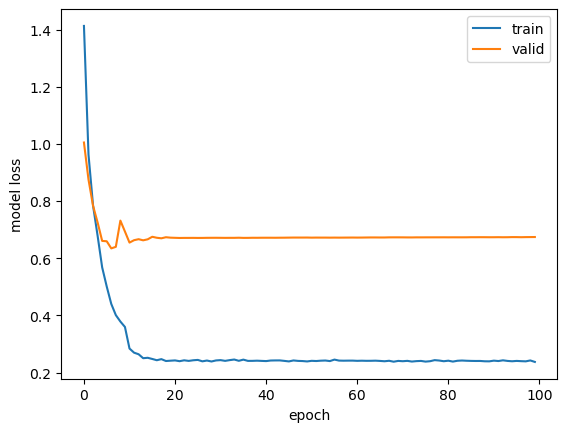

In [19]:

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_history.png')
plt.show()

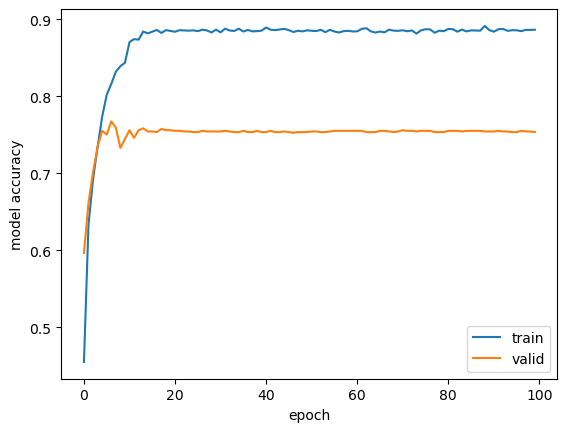

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_accuracy_history.png')
plt.show()

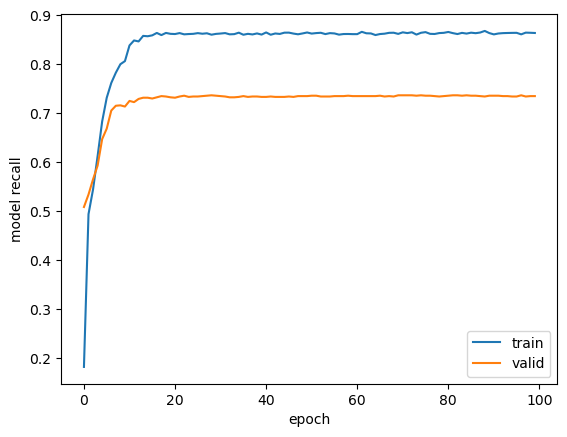

In [21]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.ylabel('model recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_accuracy_history.png')
plt.show()

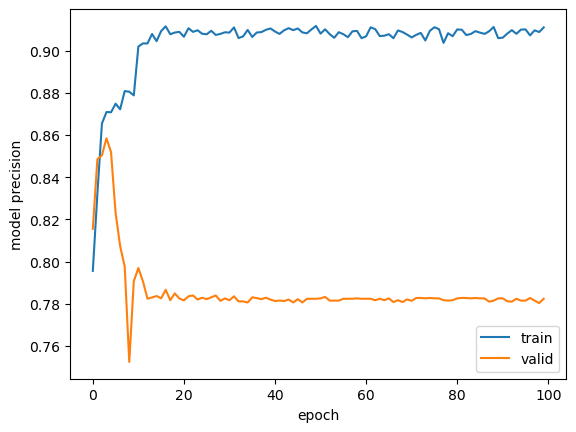

In [22]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.ylabel('model precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_accuracy_history.png')
plt.show()

# Run This Section in case of 3 Labels( Merged under represented classes)

In [37]:

def change(x):
    if x in ['RACISM','SEXISM','BULLYING']:
        x ='HATE_SPEECH'
    return x

In [ ]:
max_text_length=300
embed_dim = 300 # size of fasttext vector(fastmodel in my case)
#load fast text vectorizer and the tokenizer
tokenizer= Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index)+1

In [ ]:
templiste=[]
for element in x_train:
    templiste.append(str(element))
x_train=[]
x_train=templiste

templiste=[]
for element in x_validation:
    templiste.append(str(element))
x_validation=[]
x_validation=templiste
templiste=[]
for element in x_test:
    templiste.append(str(element))
x_test=[]
x_test=templiste

In [ ]:
y_train1=[change(x) for x in y_train]
y_validation1=[change(x) for x in y_validation]
y_test1=[change(x) for x in y_test]
y_train=y_train1
y_validation=y_validation1
y_test=y_test1

In [ ]:
temp= tokenizer.texts_to_sequences(x_train)
x_train_padded=pad_sequences(temp, maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_validation)
x_validation_padded=pad_sequences(temp,maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_test)
x_test_padded=pad_sequences(temp, maxlen=max_text_length, padding='pre')

In [ ]:
# integer encode the data and padd it
y_train_encoded =pd.get_dummies(y_train).values
y_validation_encoded =pd.get_dummies(y_validation).values
y_test_encoded =pd.get_dummies(y_test).values

In [ ]:
# integer encode the data and padd it
temp= tokenizer.texts_to_sequences(x_train)
x_train_padded=pad_sequences(temp, maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_validation)
x_validation_padded=pad_sequences(temp,maxlen= max_text_length, padding='pre')
temp=tokenizer.texts_to_sequences(x_test)
x_test_padded=pad_sequences(temp, maxlen=max_text_length, padding='pre')

In [ ]:
y_train_encoded = np.array(y_train)
y_validation_encoded = np.array(y_validation)
y_test_encoded=np.array(y_test)

In [ ]:

with open('d:/OMDENA/Marseile/french_tokenizer1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from numpy import zeros
embed_matrix=zeros((vocab_size,embed_dim))
for word, i in tokenizer.word_index.items():
    embed_vector= fastvectorizer[word]#fastvectorizer.wv[word]
      
    if embed_vector is not None:
        embed_matrix[i]=embed_vector
        


In [ ]:
fastvectorizer = None

In [ ]:
save_dir=os.path.join(os.getcwd(),'saved_models')
model_name='d:/omdena/Marseile/models/RNN_T_FastText_français_24_01_2023_3labe.{epoch:03d}.h5'

#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
filepath=os.path.join(save_dir,model_name)
checkpoint= ModelCheckpoint(filepath=filepath,monitor='val_loss',)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, cooldown=0, patience=3, min_lr=0.5e-6)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,  patience=5, min_lr=0.001)
callbacks=[checkpoint,reduce_lr]


In [52]:
#RNN model
modele1 = Sequential()
modele1.add(e)
modele1.add(GlobalAveragePooling1D())
modele1.add(Dropout(0.3))
modele1.add(Dense(300, activation="relu"))
modele1.add(Dropout(0.3))
modele1.add(Dense(100, activation="relu"))
modele1.add(Dense(3, activation='softmax'))
modele1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=["accuracy",Recall(),Precision()])
print (modele1.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          3507000   
                                                                 
 global_average_pooling1d_4   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 300)               0         
                                                                 
 dense_12 (Dense)            (None, 300)               90300     
                                                                 
 dropout_9 (Dropout)         (None, 300)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                      

In [54]:
history = modele1.fit(x_train_padded, y_train_encoded,  batch_size=32, validation_data=(x_validation_padded, y_validation_encoded), callbacks=callbacks,epochs=100,verbose=1)


Epoch 1/100
305/305 [==============================] - 9s 25ms/step - loss: 0.8535 - accuracy: 0.5790 - recall_3: 0.3231 - precision_3: 0.7499 - val_loss: 0.5357 - val_accuracy: 0.7521 - val_recall_3: 0.7053 - val_precision_3: 0.7760 - lr: 0.0010
Epoch 2/100
305/305 [==============================] - 7s 24ms/step - loss: 0.4393 - accuracy: 0.8258 - recall_3: 0.8031 - precision_3: 0.8462 - val_loss: 0.4508 - val_accuracy: 0.8144 - val_recall_3: 0.7964 - val_precision_3: 0.8248 - lr: 0.0010
Epoch 3/100
305/305 [==============================] - 8s 25ms/step - loss: 0.3063 - accuracy: 0.8797 - recall_3: 0.8709 - precision_3: 0.8878 - val_loss: 0.3332 - val_accuracy: 0.8571 - val_recall_3: 0.8506 - val_precision_3: 0.8655 - lr: 0.0010
Epoch 4/100
305/305 [==============================] - 8s 25ms/step - loss: 0.2245 - accuracy: 0.9117 - recall_3: 0.9073 - precision_3: 0.9171 - val_loss: 0.5085 - val_accuracy: 0.8087 - val_recall_3: 0.8013 - val_precision_3: 0.8140 - lr: 0.0010
Epoch 5/100


Epoch 34/100
305/305 [==============================] - 8s 25ms/step - loss: 0.0477 - accuracy: 0.9852 - recall_3: 0.9850 - precision_3: 0.9854 - val_loss: 0.3737 - val_accuracy: 0.8867 - val_recall_3: 0.8834 - val_precision_3: 0.8885 - lr: 5.0000e-07
Epoch 35/100
305/305 [==============================] - 8s 27ms/step - loss: 0.0473 - accuracy: 0.9842 - recall_3: 0.9839 - precision_3: 0.9843 - val_loss: 0.3738 - val_accuracy: 0.8867 - val_recall_3: 0.8851 - val_precision_3: 0.8894 - lr: 5.0000e-07
Epoch 36/100
305/305 [==============================] - 8s 25ms/step - loss: 0.0461 - accuracy: 0.9848 - recall_3: 0.9845 - precision_3: 0.9850 - val_loss: 0.3738 - val_accuracy: 0.8859 - val_recall_3: 0.8834 - val_precision_3: 0.8878 - lr: 5.0000e-07
Epoch 37/100
305/305 [==============================] - 7s 24ms/step - loss: 0.0474 - accuracy: 0.9841 - recall_3: 0.9839 - precision_3: 0.9842 - val_loss: 0.3739 - val_accuracy: 0.8867 - val_recall_3: 0.8859 - val_precision_3: 0.8895 - lr: 5.0

Epoch 99/100
305/305 [==============================] - 7s 25ms/step - loss: 0.0455 - accuracy: 0.9851 - recall_3: 0.9846 - precision_3: 0.9852 - val_loss: 0.3759 - val_accuracy: 0.8834 - val_recall_3: 0.8826 - val_precision_3: 0.8870 - lr: 5.0000e-07
Epoch 100/100
305/305 [==============================] - 8s 25ms/step - loss: 0.0462 - accuracy: 0.9842 - recall_3: 0.9842 - precision_3: 0.9845 - val_loss: 0.3759 - val_accuracy: 0.8834 - val_recall_3: 0.8826 - val_precision_3: 0.8870 - lr: 5.0000e-07


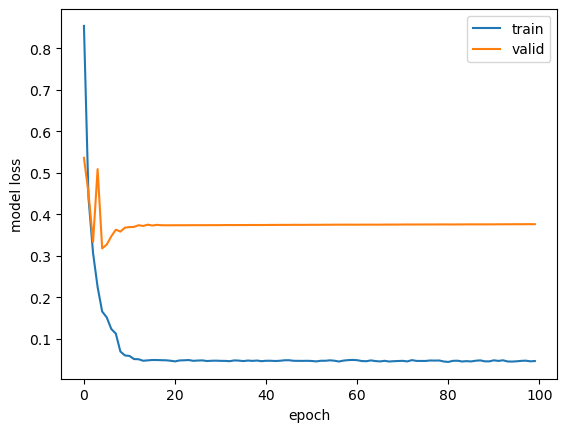

In [57]:

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_history.png')
plt.show()

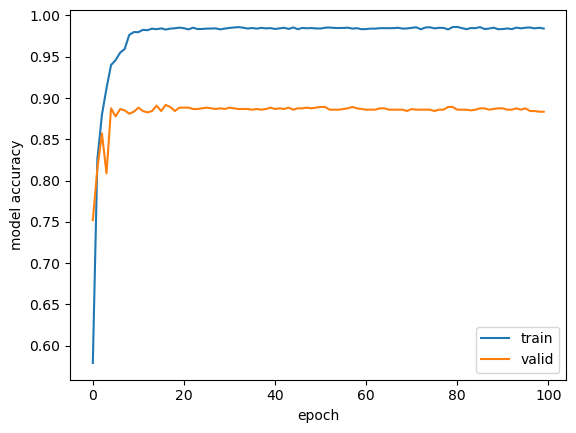

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_accuracy_history.png')
plt.show()

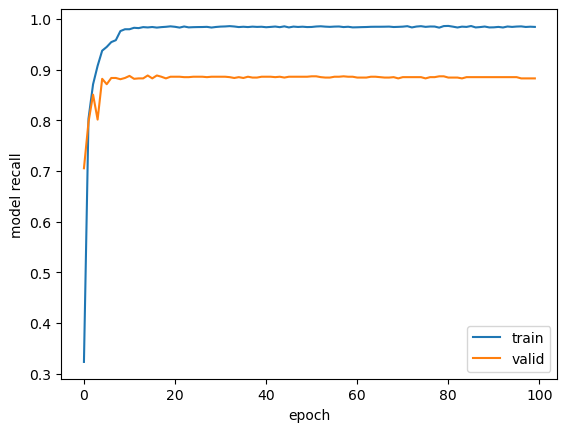

In [63]:
plt.plot(history.history['recall_3'])
plt.plot(history.history['val_recall_3'])
plt.ylabel('model recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_accuracy_history.png')
plt.show()

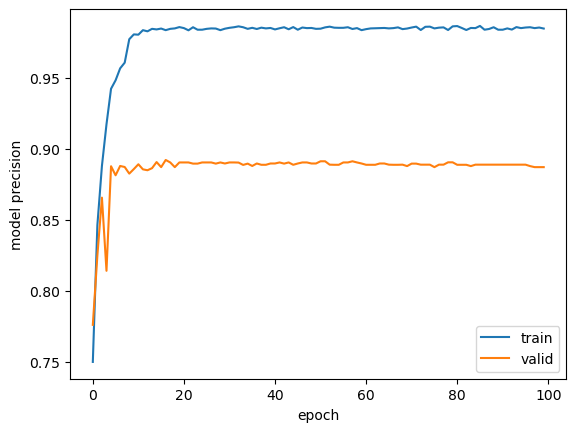

In [64]:
plt.plot(history.history['precision_3'])
plt.plot(history.history['val_precision_3'])
plt.ylabel('model precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('train_accuracy_history.png')
plt.show()

In [55]:
modele1.evaluate(x_test_padded,y_test_encoded)

39/39 [==============================] - 0s 4ms/step - loss: 0.3566 - accuracy: 0.8901 - recall_3: 0.8884 - precision_3: 0.8943


[0.3566017150878906, 0.890073835849762, 0.8884331583976746, 0.894302248954773]

In [ ]:
history = modele1.fit(x_train_padded, y_train_encoded,  batch_size=16, validation_data=(x_validation_padded, y_validation_encoded), callbacks=callbacks,epochs=60,verbose=1)


In [ ]:
modele1.evaluate(x_test_padded,y_test_encoded)

In [ ]:
model= load_model("saved_models/Model_RNN_T_FastText_français_Amazon_24_05_2021_bis_newparam.003.h5")

history = model.fit(x_train_padded, y_train_encoded,  batch_size=128, validation_data=(x_validation_padded, y_validation_encoded), callbacks=callbacks,epochs=20,verbose=1)


In [ ]:
#oad saved model and test with new data
model= load_model("saved_models/Model_RNN_T_FastText_français_Amazon_24_05_2021_bis_newparam.003.h5")
model.evaluate(x_test_padded,y_test_encoded)

In [ ]:
model= load_model("saved_models/Model_LSTM_T_FastText_français_Amazon_Twitt_11_05_2021_bin.002.h5")
model.evaluate(x_test_padded,y_test_encoded)

In [ ]:
model= load_model("saved_models/Model_LSTM_T_FastText_français_Amazon_Twitt_unbal_Amaz_Maj_16_05_2021_bin.003.h5")
model.evaluate(x_test_padded,y_test_encoded)

In [ ]:
model= load_model("saved_models/Model_LSTM_T_FastText_français_Amazon_23_05_2021_bin.008.h5")
model.evaluate(x_train_padded,y_train_encoded)

In [ ]:
model= load_model("saved_models/Model_LSTM_T_FastText_français_Amazon_23_05_2021_bin.003.h5")
model.evaluate(x_test_padded,y_test_encoded)

In [ ]:
model= load_model("saved_models/Model_LSTM_T_FastText_français_Amazon_23_05_2021_bin.002.h5")
modele1.evaluate(x_test_padded,y_test_encoded)

In [ ]:
model= load_model("D:/RightInnov/saved_models/detect_dz.h5")
saved_model.save(model,"D:/RightInnov/saved_models/savedformat")